In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
np.random.seed(42)


In [5]:
# Define image dimensions and path to dataset
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
DATASET_PATH = '/kaggle/input/leapgestrecog/leapGestRecog'

# Function to load images and labels
def load_images_and_labels(dataset_path, img_width, img_height):
    images = []
    labels = []
    for subject_folder in os.listdir(dataset_path):
        subject_path = os.path.join(dataset_path, subject_folder)
        for gesture_folder in os.listdir(subject_path):
            gesture_path = os.path.join(subject_path, gesture_folder)
            label = gesture_folder.split('_')[1]
            for img_file in os.listdir(gesture_path):
                img_path = os.path.join(gesture_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (img_width, img_height))
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load images and labels
X, y = load_images_and_labels(DATASET_PATH, IMG_WIDTH, IMG_HEIGHT)

# Reshape images to add the channel dimension
X = X.reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

# Normalize pixel values
X = X.astype('float32') / 255.0

# Encode labels with LabelBinarizer (from previous step)
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

# Ensure the labels are in a 2D shape
y = np.array(y)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [6]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_binarizer.classes_), activation='softmax')  # Output layer with the correct number of classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,096 (12.61 MB)

 Trainable params: 3,305,096 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])


Epoch 1/20


I0000 00:00:1725468281.491189     115 service.cc:145] XLA service 0x7dfe4c001ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725468281.491254     115 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725468281.491260     115 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 13/438 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1741 - loss: 2.0416

I0000 00:00:1725468286.330885     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.7394 - loss: 0.7387 - val_accuracy: 0.9983 - val_loss: 0.0075
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9876 - loss: 0.0382 - val_accuracy: 0.9990 - val_loss: 0.0039
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9923 - loss: 0.0211 - val_accuracy: 0.9980 - val_loss: 0.0059
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9932 - loss: 0.0174 - val_accuracy: 0.9990 - val_loss: 0.0029
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9965 - loss: 0.0107 - val_accuracy: 0.9977 - val_loss: 0.0053
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9922 - loss: 0.0244 - val_accuracy: 0.9997 - val_loss: 5.6551e-04
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9961 - loss: 0.0104 - val_accuracy: 1.0000 - val_loss: 9.9175e-05
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9969 - loss: 0.0102 - val_accura

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.3825e-04
Test Accuracy: 1.0000


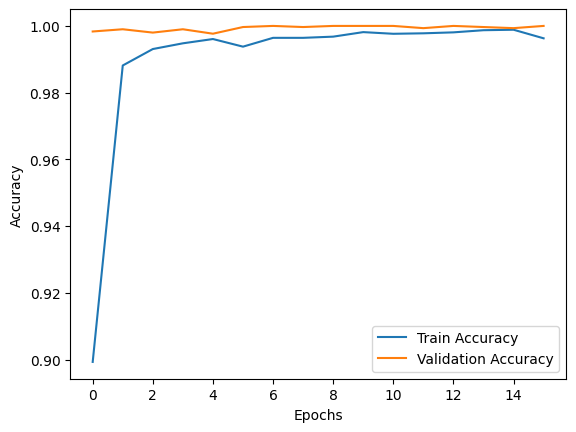

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [10]:
# Save the trained model
model.save('/kaggle/working/hand_gesture_recognition_model.h5')


In [14]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/kaggle/working/hand_gesture_recognition_model.h5')

# Predict on a new image
def predict_gesture(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img.reshape(1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS).astype('float32') / 255.0
    prediction = model.predict(img)
    return label_binarizer.inverse_transform(prediction)

# Example usage
prediction = predict_gesture('/kaggle/input/leapgestrecog/leapGestRecog/01/07_ok/frame_01_07_0001.png')
print(f'Predicted Gesture: {prediction[0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
Predicted Gesture: ok
